In [116]:
import yfinance as yf
import pandas as pd
from IPython.display import display, Math, Latex, HTML
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Simulation Monte Carlo (GBM)

$$
S_{t+1} = S_t \cdot \exp\left[(\mu - \frac{\sigma^2}{2})dt + \sigma \cdot \sqrt{dt} \cdot Z\right]
$$
On simule plusieurs chemins de prix futurs d’un actif en y ajoutant une composante aléatoire (modélisant l’incertitude du marché).
Cela permet d’estimer, par exemple, la probabilité que le prix dépasse le strike, ou la valeur moyenne de l’option à l’échéance.

In [98]:
tickers = ['NVDA', 'AMZN']
start_date = '2023-06-18'
end_date = '2024-06-18'

# Télécharger les données AVEC ajustement
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)

# Aplatir les colonnes
data.columns = [f"{col[0]}_{col[1]}" for col in data.columns]

# Accès aux clôtures ajustées
nvda = data["Close_NVDA"]
amzn = data["Close_AMZN"]

print(nvda.head())

[*********************100%***********************]  2 of 2 completed

Date
2023-06-20    43.781055
2023-06-21    43.018528
2023-06-22    42.998539
2023-06-23    42.183048
2023-06-26    40.607010
Name: Close_NVDA, dtype: float64


In [100]:
log_returns = np.log(nvda / nvda.shift(1)).dropna()
mu = log_returns.mean()
sigma = log_returns.std()
last_price = nvda[-1]

mu, sigma, last_price

/var/folders/rw/drl9t71j2xj0m4tt81d8y0_80000gp/T/ipykernel_10225/3211295645.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = nvda[-1]


(np.float64(0.004382110601366964),
 np.float64(0.02745721180393225),
 np.float64(130.9386444091797))

In [101]:
num_days = 252
num_simulations = 1000
dt = 1 / num_days

simulations = np.zeros((num_days, num_simulations))
simulations[0] = last_price

In [102]:
for t in range(1, num_days):
    z = np.random.standard_normal(num_simulations)
    simulations[t] = simulations[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

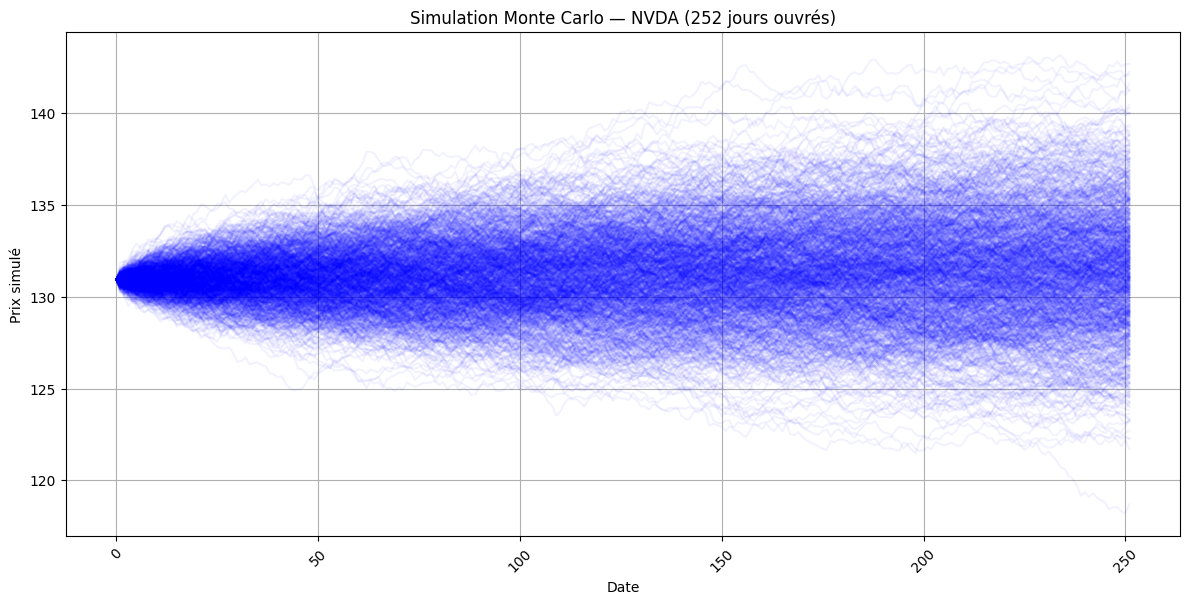

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(simulations, color='blue', alpha=0.05)
plt.title("Simulation Monte Carlo — NVDA (252 jours ouvrés)")
plt.xlabel("Date")
plt.ylabel("Prix simulé")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Prix moyen attendu : 131.46 €
Écart-type final : 3.44
5% des scénarios sont en-dessous de : 125.75 €
5% des scénarios sont au-dessus de : 137.32 €
Probabilité que le prix tombe sous 120 € : 0.1%
Valeur estimée du call strike 13 : 112.68 €


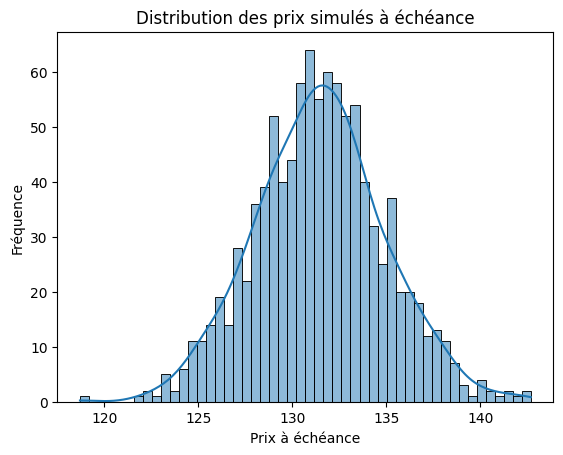

In [117]:
expected_price = simulations[-1].mean()
std_price = simulations[-1].std()
percentile_5 = np.percentile(simulations[-1], 5)
percentile_95 = np.percentile(simulations[-1], 95)

print(f"Prix moyen attendu : {expected_price:.2f} €")
print(f"Écart-type final : {std_price:.2f}")
print(f"5% des scénarios sont en-dessous de : {percentile_5:.2f} €")
print(f"5% des scénarios sont au-dessus de : {percentile_95:.2f} €")
seuil = 120
proba_chute = (simulations[-1] < seuil).mean()
print(f"Probabilité que le prix tombe sous {seuil} € : {proba_chute*100:.1f}%")
strike = 13
payoffs = np.maximum(simulations[-1] - strike, 0)
call_price = np.mean(payoffs) * np.exp(-0.05 * 1)  # actualisation à 5%
print(f"Valeur estimée du call strike {strike} : {call_price:.2f} €")

sns.histplot(simulations[-1], kde=True, bins=50)
plt.title("Distribution des prix simulés à échéance")
plt.xlabel("Prix à échéance")
plt.ylabel("Fréquence")
plt.show()